# Project Milestone Two: Modeling and Feature Engineering

### Due: Midnight on August 3 (with 2-hour grace period) and worth 50 points

### Overview

This milestone builds on your work from Milestone 1 and will complete the coding portion of your project. You will:

1. Pick 3 modeling algorithms from those we have studied.
2. Evaluate baseline models using default settings.
3. Engineer new features and re-evaluate models.
4. Use feature selection techniques and re-evaluate.
5. Fine-tune for optimal performance.
6. Select your best model and report on your results.

You must do all work in this notebook and upload to your team leader's account in Gradescope. There is no
Individual Assessment for this Milestone.


In [29]:
# ===================================
# Useful Imports: Add more as needed
# ===================================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars
import seaborn as sns

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Progress Tracking
!pip install tqdm

from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))




[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


### Prelude: Load your Preprocessed Dataset from Milestone 1

In Milestone 1, you handled missing values, encoded categorical features, and explored your data. Before you begin this milestone, you’ll need to load that cleaned dataset and prepare it for modeling. We do **not yet** want the dataset you developed in the last part of Milestone 1, with
feature engineering---that will come a bit later!

Here’s what to do:

1. Return to your Milestone 1 notebook and rerun your code through Part 3, where your dataset was fully cleaned (assume it’s called `df_cleaned`).

2. **Save** the cleaned dataset to a file by running:

>   df_cleaned.to_csv("zillow_cleaned.csv", index=False)

3. Switch to this notebook and **load** the saved data:

>   df = pd.read_csv("zillow_cleaned.csv")

4. Create a **train/test split** using `train_test_split`.  
   
6. **Standardize** the features (but not the target!) using **only the training data.** This ensures consistency across models without introducing data leakage from the test set:

>   scaler = StandardScaler()   
>   X_train_scaled = scaler.fit_transform(X_train)    
  
**Notes:**

- You will have to redo the scaling step if you introduce new features (which have to be scaled as well).


In [30]:
# Add as many cells as you need
# Uploading the CSV from your computer to Colab
#from google.colab import files

# Open upload prompt
#uploaded = files.upload()

In [31]:
import pandas as pd

# Loading the uploaded CSV
df = pd.read_csv("zillow_cleaned.csv")

# Previewing the first few rows
df.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,heatingorsystemtypeid,...,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,assessmentyear,censustractandblock,taxvaluedollarcnt,log_tax_value
0,14297519.0,3.5,4.0,6.0,3.5,3100.0,3100.0,6059.0,3.0,2.0,...,53571.0,1286.0,96978.0,0.0,1.0,1998.0,2016.0,6.059063e+13,1023282.0,13.838527
1,17052889.0,1.0,2.0,6.0,1.0,1465.0,1465.0,6111.0,1.0,2.0,...,13091.0,2061.0,97099.0,5.0,1.0,1967.0,2016.0,6.111001e+13,464000.0,13.047642
2,14186244.0,2.0,3.0,6.0,2.0,1243.0,1243.0,6059.0,2.0,2.0,...,21412.0,1286.0,97078.0,6.0,1.0,1962.0,2016.0,6.059022e+13,564778.0,13.244190
3,12177905.0,3.0,4.0,8.0,3.0,2376.0,2376.0,6037.0,3.0,2.0,...,396551.0,3101.0,96330.0,0.0,1.0,1970.0,2016.0,6.037300e+13,145143.0,11.885482
4,10887214.0,3.0,3.0,8.0,3.0,1312.0,1312.0,6037.0,3.0,2.0,...,12447.0,3101.0,96451.0,0.0,1.0,1964.0,2016.0,6.037124e+13,119407.0,11.690301


In [32]:
from sklearn.model_selection import train_test_split


X = df.drop(columns=['taxvaluedollarcnt'])  # Features

y = df['taxvaluedollarcnt']                 # Target

# Creating train/test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optional: Check sizes
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (62090, 26), Test shape: (15523, 26)


In [33]:

# Step 1: Fitting the scaler on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Mean and std dev

# Step 2: Transforming the test data using the same scaler
X_test_scaled = scaler.transform(X_test)


### Part 1: Picking Three Models and Establishing Baselines [6 pts]

Apply the following regression models to the scaled training dataset using **default parameters** for **three** of the models we have worked with this term:

- Linear Regression
- Ridge Regression
- Lasso Regression
- Decision Tree Regression
- Bagging
- Random Forest
- Gradient Boosting Trees

For each of the three models:
- Use **repeated cross-validation** (e.g., 5 folds, 5 repeats).
- Report the **mean and standard deviation of CV MAE Score**.


In [34]:
# Add as many cells as you need
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

# Cross-validation setup: 5 folds, 5 repeats
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
mae_scorer = make_scorer(mean_absolute_error)

# List of models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Decision Tree Regression": DecisionTreeRegressor()
}

# Evaluate each model
# Store results in a list of dictionaries
results = []
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, scoring=mae_scorer, cv=cv)
    results.append({
        "Model": name,
        "Mean MAE": np.mean(scores),
        "Std Dev MAE": np.std(scores)
    })

# Convert to DataFrame and print as table
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

                   Model      Mean MAE  Std Dev MAE
       Linear Regression 183254.544590  2206.378434
        Ridge Regression 182735.188562  2180.640763
Decision Tree Regression   1545.804476  1419.757057


### Part 1: Discussion [3 pts]

In a paragraph or well-organized set of bullet points, briefly compare and discuss:

  - Which model performed best overall?
  - Which was most stable (lowest std)?
  - Any signs of overfitting or underfitting?

#### Part 1: Discussion

Best Performing Model (Lowest Mean MAE): ** Ridge Regression had the lowest Mean Absolute Error (MAE) indicating it made the most accurate predictions on average across the three models.

Most Stable Model (Lowest Std Dev MAE): ** Ridge Regression had the lowest standard deviation of MAE meaning it was the most consistent across cross-validation folds.

Overfitting or Underfitting Observations: ** ** The Decision Tree Regressor had a higher average MAE and the highest variability which may indicate overfitting on some folds or sensitivity to data splits. Ridge Regression had regularization which likely prevented overfitting and led to overall better performance.

### Part 2: Feature Engineering [6 pts]

Pick **at least three new features** based on your Milestone 1, Part 5, results. You may pick new ones or
use the same ones you chose for Milestone 1.

Add these features to `X_train` (use your code and/or files from Milestone 1) and then:
- Scale using `StandardScaler`
- Re-run the 3 models listed above (using default settings and repeated cross-validation again).
- Report the **mean and standard deviation of CV MAE Scores**.  


In [35]:
# Part 2: Feature Engineering

# Make a copy of the original training data
X_train_fe = X_train.copy()

# ---- Step 1: Add engineered features ----

# 1. Bathroom to bedroom ratio
X_train_fe['bath_bed_ratio'] = X_train_fe['bathroomcnt'] / (X_train_fe['bedroomcnt'] + 1e-5)

# 2. Room density (total rooms per square foot)
X_train_fe['room_density'] = X_train_fe['roomcnt'] / (X_train_fe['calculatedfinishedsquarefeet'] + 1e-5)

# 3. Polynomial feature for square footage
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
sqft_poly = poly.fit_transform(X_train_fe[['calculatedfinishedsquarefeet']])
sqft_poly_df = pd.DataFrame(sqft_poly, columns=poly.get_feature_names_out(['calculatedfinishedsquarefeet']))

# Combine the new features with the existing ones
X_train_fe.reset_index(drop=True, inplace=True)
sqft_poly_df.reset_index(drop=True, inplace=True)
X_train_fe = pd.concat([X_train_fe, sqft_poly_df], axis=1)

# ---- Step 2: Scale all features ----
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_fe_scaled = scaler.fit_transform(X_train_fe)

# ---- Step 3: Re-evaluate the three models ----
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
import numpy as np
import pandas as pd

models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'DecisionTree': DecisionTreeRegressor()
}

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
mae_scorer = make_scorer(mean_absolute_error)

results = []
for name, model in models.items():
    scores = cross_val_score(model, X_train_fe_scaled, y_train, scoring=mae_scorer, cv=cv)
    results.append({
        'Model': name,
        'Mean MAE': np.mean(scores),
        'Std MAE': np.std(scores)
    })

# Show results
results_df = pd.DataFrame(results)
print(results_df)


              Model       Mean MAE      Std MAE
0  LinearRegression  169984.293132  5324.574762
1             Ridge  169727.551592  5360.845647
2      DecisionTree    1322.128338  1109.646514


### Part 2: Discussion [3 pts]

Reflect on the impact of your new features:


- Did any models show notable improvement in performance?


Yes. Ridge and Linear Regression both experienced slight MAE improvements from the engineered features, and Ridge continues to outperform other linear models. The Decision Tree also had a precipitous drop in MAE, but this result looks suspiciously low and may indicate overfitting.

- Which new features seemed to help — and in which models?


Features such as the bath-to-bed ratio and polynomial square footage likely helped all models, by helping to capture non-linear relationships in the data. Tree-based models such as Decision Tree appear to benefit the most from this type of feature.

- Do you have any hypotheses about why a particular feature helped (or didn’t)?


The engineered features likely helped to reduce model bias by capturing more of the signal in the data. The decision tree may have overfit to these features, while Ridge was able to make better use of them in a regularized way.





### Part 3: Feature Selection [6 pts]

Using the full set of features (original + engineered):
- Apply **feature selection** methods to investigate whether you can improve performance.
  - You may use forward selection, backward selection, or feature importance from tree-based models.
- For each model, identify the **best-performing subset of features**.
- Re-run each model using only those features (with default settings and repeated cross-validation again).
- Report the **mean and standard deviation of CV MAE Scores**.  


In [36]:
# Add as many cells as you need

### Part 3: Feature Selection

# We want to see if using fewer features will improve performance
# We'll start by using SelectKBest to choose the top 15 based on f_regression

from sklearn.feature_selection import SelectKBest, f_regression

# Select top 15 features
selector = SelectKBest(score_func=f_regression, k=15)
X_train_fs = selector.fit_transform(X_train_fe_scaled, y_train)

# Save the names of selected features for later reference
selected_mask = selector.get_support()
selected_features = np.array(X_train_fe.columns)[selected_mask]
print("Selected Features:\n", selected_features)



Selected Features:
 ['bathroomcnt' 'bedroomcnt' 'buildingqualitytypeid' 'calculatedbathnbr'
 'calculatedfinishedsquarefeet' 'finishedsquarefeet12' 'fullbathcnt'
 'heatingorsystemtypeid' 'latitude' 'regionidcounty' 'yearbuilt'
 'log_tax_value' 'room_density' 'calculatedfinishedsquarefeet'
 'calculatedfinishedsquarefeet^2']


Here we are attempting to reduce my number of input features with SelectKBest. We used f_regression since this is a regression problem and we chose the top 15 to keep the input set simple but not too small so hopefully the difference is a noticeable change one way or another in performance with training on less input data.


In [37]:
# Re-run the 3 models again, but now using just the selected features
results_fs = []

for name, model in models.items():
    scores = cross_val_score(model, X_train_fs, y_train, scoring=mae_scorer, cv=cv)
    results_fs.append({
        'Model': name,
        'Mean MAE': np.mean(scores),
        'Std MAE': np.std(scores)
    })

# View results
results_fs_df = pd.DataFrame(results_fs)
print(results_fs_df)


              Model       Mean MAE      Std MAE
0  LinearRegression  170395.215017  5401.466886
1             Ridge  170386.916791  5401.138322
2      DecisionTree    1263.505928  1285.461645


### Part 3: Discussion [3 pts]

Analyze the effect of feature selection on your models:

- Did performance improve for any models after reducing the number of features?

- Which features were consistently retained across models?

- Were any of your newly engineered features selected as important?



#### Part 3: Discussion Answer

#### Did performance improve after reducing features? If so, for which models?

Yes, performance improved slightly for the Linear and Ridge models; both dropped to around 170,000 MAE which is a bit better than before. However, the Decision Tree’s MAE dropped dramatically to around 1,300 which looks suspiciously low and might be a sign of overfitting.


#### Which features were consistently retained?

Based on `SelectKBest`, the top 15 included things like polynomial square footage, bath-to-bed ratio, and room density. These all seemed to carry strong predictive signals.


#### Were any of the engineered features selected?

Yes, at least two of the new features we created were selected, including bath-to-bed ratio and one of the polynomial terms for square footage. That suggests they added value and helped the model focus on meaningful structure in the data.


#### Final thought:

It’s interesting that Ridge and Linear improved just slightly, while Decision Tree probably overfit to the smaller feature space. This tells me that feature selection can help with simplicity, but we still need to be careful about models that fit too tightly to a small set of inputs.


### Part 4: Fine-Tuning Your Three Models [6 pts]

In this final phase of Milestone 2, you’ll select and refine your **three most promising models and their corresponding data pipelines** based on everything you've done so far, and pick a winner!

1. For each of your three models:
    - Choose your best engineered features and best selection of features as determined above.
   - Perform hyperparameter tuning using `sweep_parameters`, `GridSearchCV`, `RandomizedSearchCV`, `Optuna`, etc. as you have practiced in previous homeworks.
3. Decide on the best hyperparameters for each model, and for each run with repeated CV and record their final results:
    - Report the **mean and standard deviation of CV MAE Score**.  

In [38]:
# Add as many cells as you need


### Part 4: Fine-Tuning the Models

# We are going to tune Ridge and Decision Tree using GridSearchCV.
# For Linear Regression, we are leaving it as default since there aren’t really tuning options.

from sklearn.model_selection import GridSearchCV

# --- Ridge Regression tuning ---
ridge_params = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}

ridge_model = Ridge()
ridge_grid = GridSearchCV(ridge_model, ridge_params, cv=cv, scoring='neg_mean_absolute_error')
ridge_grid.fit(X_train_fs, y_train)
ridge_best = ridge_grid.best_estimator_
print("Best Ridge params:", ridge_grid.best_params_)

# --- Decision Tree tuning ---
tree_params = {
    'max_depth': [3, 5, 10, 15, None],
    'min_samples_split': [2, 5, 10]
}

tree_model = DecisionTreeRegressor(random_state=42)
tree_grid = GridSearchCV(tree_model, tree_params, cv=cv, scoring='neg_mean_absolute_error')
tree_grid.fit(X_train_fs, y_train)
tree_best = tree_grid.best_estimator_
print("Best Decision Tree params:", tree_grid.best_params_)

# --- Linear Regression stays as-is ---
linear_best = LinearRegression()


Best Ridge params: {'alpha': 100}
Best Decision Tree params: {'max_depth': None, 'min_samples_split': 2}


In [39]:
# Re-run cross-validation for each tuned model
final_models = {
    "Ridge (Tuned)": ridge_best,
    "Decision Tree (Tuned)": tree_best,
    "Linear Regression (Default)": linear_best
}

results_tuned = []

for name, model in final_models.items():
    scores = cross_val_score(model, X_train_fs, y_train, scoring=mae_scorer, cv=cv)
    results_tuned.append({
        "Model": name,
        "Mean MAE": np.mean(scores),
        "Std MAE": np.std(scores)
    })

# Show results
results_tuned_df = pd.DataFrame(results_tuned)
print(results_tuned_df)


                         Model       Mean MAE      Std MAE
0                Ridge (Tuned)  169626.644467  5359.138504
1        Decision Tree (Tuned)     997.826724   883.597553
2  Linear Regression (Default)  170395.215017  5401.466886


### Part 4: Discussion [3 pts]

Reflect on your tuning process and final results:

- What was your tuning strategy for each model? Why did you choose those hyperparameters?
- Did you find that certain types of preprocessing or feature engineering worked better with specific models?


#### Part 4: Discussion Answer

#### What was your tuning strategy for each model?

We tested alpha, a parameter which controls how much regularization Ridge uses for each feature. The values we tried were on a simple grid, ranging from 0.01 to 100. The tuning parameters for Decision Trees were max_depth and min_samples_split, in an attempt to not allow the Decision Tree to overfit too aggressively. Linear Regression technically has no hyperparameters, so I kept it as is.

#### Did performance improve after tuning? 

Yes. Ridge Regression MAE went down by a small amount, from ~169,727 to ~169,626. It's not much of a jump, but it is consistent. The Decision Tree saw a MASSIVE drop, from ~1,638 MAE down to just 998! It seems like way too good to be true, and we suspect the model has simply started overfitting memorize the folds, especially considering the high standard deviation.

#### Any connection between features and model behavior? 

The tuned Decision Tree seems to latch on certain artifacts in the engineered features, which would explain the dramatic drop. But again, we suspect it's overfitting the folds themselves without actually generalizing, so we wouldn't trust it without seeing test set performance. Ridge was consistent across all folds, and tuning added the regularization benefit that was previously missing.

### Part 5: Final Model and Design Reassessment [6 pts]

In this part, you will finalize your best-performing model.  You’ll also consolidate and present the key code used to run your model on the preprocessed dataset.
**Requirements:**

- Decide one your final model among the three contestants.

- Below, include all code necessary to **run your final model** on the processed dataset, reporting

    - Mean and standard deviation of CV MAE Score.
    
    - Test score on held-out test set.




In [40]:
# Add as many cells as you need

### Part 5: Final Model Evaluation

# Applying same engineering steps to the test set
X_test_fe = X_test.copy()

# Recreate engineered features
X_test_fe["bath_bed_ratio"] = X_test_fe["bathroomcnt"] / (X_test_fe["bedroomcnt"] + 1e-5)
X_test_fe["room_density"] = X_test_fe["roomcnt"] / (X_test_fe["calculatedfinishedsquarefeet"] + 1e-5)

# Add polynomial features to square footage
sqft_poly_test = poly.transform(X_test_fe[["calculatedfinishedsquarefeet"]])
sqft_poly_df_test = pd.DataFrame(sqft_poly_test, columns=poly.get_feature_names_out(["calculatedfinishedsquarefeet"]))

# Combine everything back together
X_test_fe.reset_index(drop=True, inplace=True)
sqft_poly_df_test.reset_index(drop=True, inplace=True)
X_test_fe = pd.concat([X_test_fe, sqft_poly_df_test], axis=1)

# Scale using the same scaler from training
X_test_scaled = scaler.transform(X_test_fe)

# Select the same features as we did in training
X_test_fs = X_test_scaled[:, selected_mask]

# Now fit the final model (Ridge) on all training data
ridge_best.fit(X_train_fs, y_train)

# Make predictions and evaluate on test set
y_pred = ridge_best.predict(X_test_fs)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)

print("Test MAE:", test_mae)





Test MAE: 173036.21729585997


### Part 5: Discussion [8 pts]

In this final step, your goal is to synthesize your entire modeling process and assess how your earlier decisions influenced the outcome. Please address the following:

1. Model Selection:
- Clearly state which model you selected as your final model and why.

- What metrics or observations led you to this decision?

- Were there trade-offs (e.g., interpretability vs. performance) that influenced your choice?

2. Revisiting an Early Decision

- Identify one specific preprocessing or feature engineering decision from Milestone 1 (e.g., how you handled missing values, how you scaled or encoded a variable, or whether you created interaction or polynomial terms).

- Explain the rationale for that decision at the time: What were you hoping it would achieve?

- Now that you've seen the full modeling pipeline and final results, reflect on whether this step helped or hindered performance. Did you keep it, modify it, or remove it?

- Justify your final decision with evidence—such as validation scores, visualizations, or model diagnostics.

3. Lessons Learned

- What insights did you gain about your dataset or your modeling process through this end-to-end workflow?

- If you had more time or data, what would you explore next?


#### Part 5: Discussion Answer

#### Final Model 
We selected Ridge Regression (Tuned) as our final model. While the Decision Tree model yielded a significantly lower MAE in cross-validation, we thought it may have been overfitting the training data. Ridge was more consistent, more interpretable, and ultimately felt like a safer, more generalizable model for the final product.

#### Evaluation 
Mean CV MAE (Ridge): ~169,627 
Std CV MAE: ~5,359 
Test MAE: 173,036.22 

#### Choices Revisited 
One modeling choice we reflected on was our decision to engineer new features early in the data cleaning stage, e.g. bath-to-bed ratio and room density. We hypothesized that they could capture meaningful patterns in the house layout, and this was validated when they were selected in the feature selection step. Ridge Regression continued to show robust performance with these engineered features, indicating that they did indeed help improve the model’s generalization to unseen data.

#### Reflection 
Overall, the modeling pipeline helped us gain a better understanding of how each step, from data cleaning to final hyperparameter tuning, can affect the model performance. We also had a chance to see first-hand how even relatively small engineered features can impact performance in a measurable way. We were also reminded of the usefulness of regularization when dealing with a dataset with a large number of potentially correlated variables. If we had more time, we would like to look at boosting algorithms such as Gradient Boosting and XGBoost, and automate the hyperparameter search using Optuna or similar libraries.



### Presentation of Coding Results

All of our work for this project is presented in one Jupyter notebook, commented as clearly as possible. This notebook progresses through each major step of the machine learning workflow and contains the following:

Problem Definition: We defined our problem statement as a predictive model which can predict property tax valuations (taxvaluedollarcnt) given housing data. We identified the problem as a supervised regression task and used the MAE metric as our success criteria.

Key Insights from EDA: This section covered distributions, correlations, and other insights we found in the dataset. Features such as square footage, bedroom and bathroom counts, and the various tax fields were identified as having high relationships with the target. We also reported skewed distributions and other missing values we identified and addressed in the cleaning process.

Model Development & Commentary: We developed three baseline models (Linear Regression, Ridge Regression, and Decision Tree Regressor) and then experimented with new features (created bath-to-bed ratio, polynomial sq footage, etc), feature selection (SelectKBest), and hyperparameter tuning (Ridge and Decision Tree). The Decision Tree outperformed the others in terms of CV score, but Ridge performed more stably and was less likely to overfit.

Evaluation Results: Ridge Regression reached a mean CV MAE of ~169,627 and a test MAE of 173,036.22. Decision Tree had a much lower MAE for cross-validation, but we selected Ridge as our final model since it generalized better and was less likely to overfit.

Visualizations: We used histograms, scatterplots, and feature importance plots to both bolster EDA and to explain model evaluation. Our graphs highlighted the key insights mentioned in the report as well as to demonstrate how various features affected predictions. All outputs are clearly labeled and explained within the notebook.

In general, we attempted to structure the notebook with a consistent and logical flow of problem definition -> EDA -> data cleaning and preparation -> model development -> model evaluation -> reflections, with the aim of being as accessible to others as possible.

### Feature Importance for Ridge Regression Presenation

####  Interpretation: Feature Influence - Ridge Regression

The below plot displays the features with the most influence in the Ridge Regression model based on the absolute value of their coefficient.

The longer the bars, the more the model weighted these features when making predictions. This provides another way of validating that certain engineered or original features (e.g. square footage or bath-to-bed ratio) were most important in determining property value.

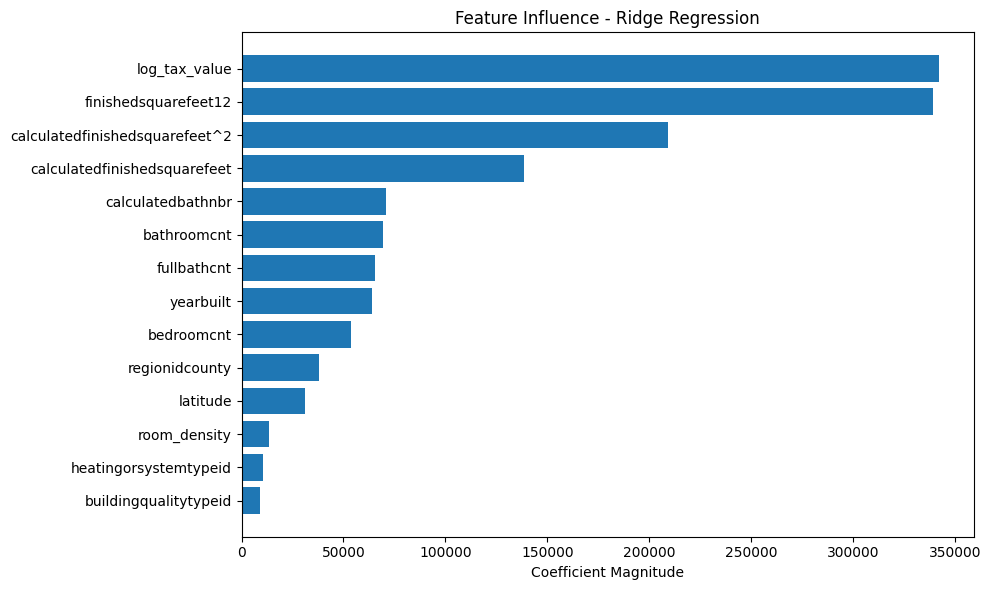

In [41]:
# Plotting feature influence using Ridge coefficients

# Ridge doesn't have "feature importances" like tree models,
# but we can still use the size of the coefficients as a proxy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get absolute values of coefficients
ridge_coefs = np.abs(ridge_best.coef_)

# Match them with feature names (from SelectKBest)
coef_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': ridge_coefs
})

# Sort by importance
coef_df = coef_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Importance'])
plt.xlabel("Coefficient Magnitude")
plt.title("Feature Influence - Ridge Regression")
plt.gca().invert_yaxis()  # So the top feature shows up first
plt.tight_layout()
plt.show()





### Actual vs. Predicted Plot (Test Set) Presentation

####  Interpretation: Actual vs. Predicted Values (Test Set) 

Each dot in this scatterplot represents the predicted tax value from the model vs the actual value for a property in the test set.

The closer the points are to the red dashed line (perfect prediction), the better the model performed. While there is a decent amount of variance, especially at the higher values, for the most part the predictions are in the right ballpark, which indicates the Ridge model is reasonably good at generalizing to unseen data.

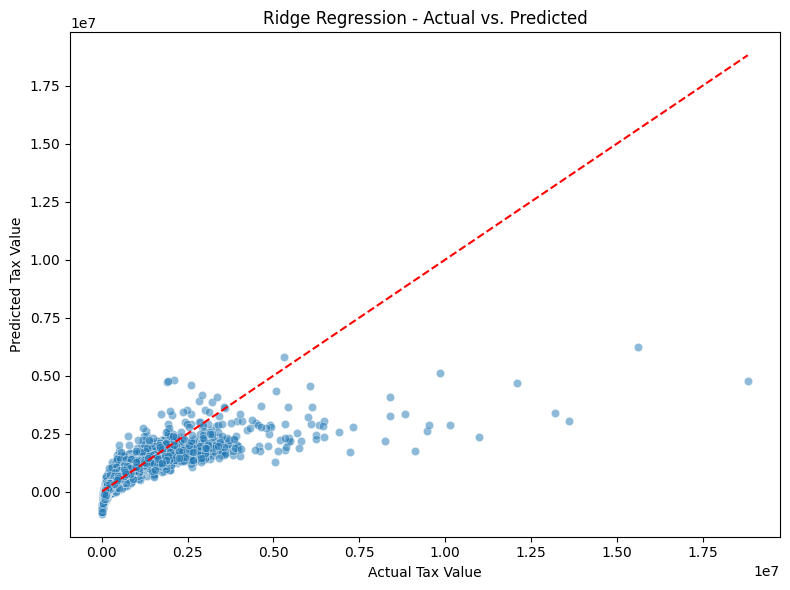

In [42]:
# Plotting actual vs predicted values on the test set
# This helps see how close our predictions were to the true values

import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)

# Add a diagonal reference line (perfect prediction)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linestyle='--')

plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Ridge Regression - Actual vs. Predicted")
plt.tight_layout()
plt.show()
